In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import random
import json
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
from datetime import datetime
import csv
from textblob import TextBlob


In [10]:
dc_df_raw = pd.read_csv('output.csv')
meta_df_raw = pd.read_csv('meta.csv')

In [11]:
dc_df_raw.head(5)

,user_id,name,time,rating,text,pics,resp,gmap_id
0,107074390665313624214,Monica Rivera,1558272538424,4.0,The venue is underground. Nice spot to grab a ...,[{'url': ['https://lh5.googleusercontent.com/p...,NaN,0x89b7b7851b06ef6b:0x5f356b1eb1da27
1,104256407771930872120,Petre Ene,1551027526726,4.0,"the food is really good, I had a great experie...",[{'url': ['https://lh5.googleusercontent.com/p...,NaN,0x89b7b7851b06ef6b:0x5f356b1eb1da27
2,114405225879020100938,Jacqui London,1566209658391,5.0,This yummy and inexpensive canteen in the bowe...,NaN,NaN,0x89b7b7851b06ef6b:0x5f356b1eb1da27
3,107718711786444128636,George W Jones 111,1575038843630,1.0,If it was possible to give less than 1 star I ...,NaN,NaN,0x89b7b7851b06ef6b:0x5f356b1eb1da27
4,115862049965497934152,Guillaume Lieb,1502129103994,4.0,Chocolates chips scones are delicious ! 👌,[{'url': ['https://lh5.googleusercontent.com/p...,NaN,0x89b7b7851b06ef6b:0x5f356b1eb1da27


In [17]:
meta_df_raw.head(3)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Cascade Café,"Cascade Café, 599 Constitution Ave. NW, Washin...",0x89b7b7851b06ef6b:0x5f356b1eb1da27,Cafeteria-style dining at the National Gallery...,38.892077,-77.019908,['American restaurant'],2.6,28,NaN,"[['Thursday', '11AM–3PM'], ['Friday', '11AM–3P...","{'Service options': ['Takeout', 'Dine-in', 'De...",Closed ⋅ Opens 11AM,"['0x89b7b79ad5a69a43:0xce2fab5ae44aaf7f', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
1,Joseph's Barbershop,"Joseph's Barbershop, 2624B Georgia Ave NW, Was...",0x89b7b797548dfcfd:0xe3a4b60261c60313,NaN,38.924913,-77.022886,['Barber shop'],4.3,8,NaN,"[['Thursday', '10AM–7PM'], ['Friday', '10AM–7P...",NaN,Permanently closed,"['0x89b7c81aec442c2f:0x2df3cce722072454', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
2,Valero,"Valero, 1301 Bladensburg Rd NE, Washington, DC...",0x89b7b86fa9c15391:0x895562701e8dee87,NaN,38.907500,-76.978347,['Gas station'],3.7,27,NaN,"[['Wednesday', 'Open 24 hours'], ['Thursday', ...",NaN,Open 24 hours,"['0x89b7b86edb3e8003:0xc1dde6954521707f', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


In [55]:
dc_df = dc_df_raw.drop(columns = ['name', 'pics', 'resp'])
meta_df = meta_df_raw.drop(columns=['description', 'MISC', 'state', 'relative_results', 'url', 'price', 'latitude', 'longitude'])

In [79]:
# mergining and adding sentimentality 
dc_full_df = dc_df.merge(meta_df, on='gmap_id').drop_duplicates()
dc_full_df['unix_time'] = dc_full_df['time']
dc_full_df['time'] = dc_full_df['unix_time'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
dc_full_df['sentiment'] = dc_full_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
dc_full_df['subjectivity'] = dc_full_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
dc_full_df = dc_full_df[['user_id',  'gmap_id', 'time', 'unix_time', 'rating', 'text', 'sentiment', 'subjectivity', 'name', 'avg_rating', 'num_of_reviews', 'address', 'category', 'hours']]
dc_full_df.head(3)

,user_id,gmap_id,time,unix_time,rating,text,sentiment,subjectivity,name,avg_rating,num_of_reviews,address,category,hours
0,107074390665313624214,0x89b7b7851b06ef6b:0x5f356b1eb1da27,2019-05-19 06:28:58,1558272538424,4.0,The venue is underground. Nice spot to grab a ...,0.333333,0.778571,Cascade Café,2.6,28,"Cascade Café, 599 Constitution Ave. NW, Washin...",['American restaurant'],"[['Thursday', '11AM–3PM'], ['Friday', '11AM–3P..."
2,104256407771930872120,0x89b7b7851b06ef6b:0x5f356b1eb1da27,2019-02-24 08:58:46,1551027526726,4.0,"the food is really good, I had a great experie...",0.500000,0.483333,Cascade Café,2.6,28,"Cascade Café, 599 Constitution Ave. NW, Washin...",['American restaurant'],"[['Thursday', '11AM–3PM'], ['Friday', '11AM–3P..."
4,114405225879020100938,0x89b7b7851b06ef6b:0x5f356b1eb1da27,2019-08-19 03:14:18,1566209658391,5.0,This yummy and inexpensive canteen in the bowe...,0.488333,0.743333,Cascade Café,2.6,28,"Cascade Café, 599 Constitution Ave. NW, Washin...",['American restaurant'],"[['Thursday', '11AM–3PM'], ['Friday', '11AM–3P..."


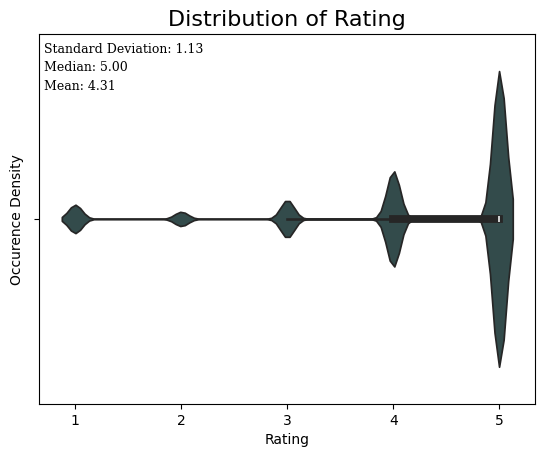

In [116]:
# rating graph

mean = dc_full_df['rating'].mean()
median = dc_full_df['rating'].median()
std_dev = dc_full_df['rating'].std()

rating_dist = sns.violinplot(x=dc_full_df['rating'],inner = 'box', color='darkslategrey')

rating_dist.text(0.01, .85, f'Mean: {mean:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)
rating_dist.text(0.01, .9, f'Median: {median:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)
rating_dist.text(0.01, .95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)

plt.title('Distribution of Rating', fontsize=16)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Occurence Density', fontsize=10)
plt.show()

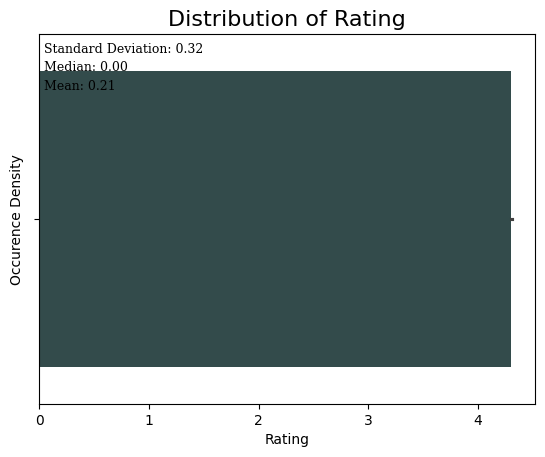

In [119]:
# rating graph

mean = dc_full_df['sentiment'].mean()
median = dc_full_df['sentiment'].median()
std_dev = dc_full_df['sentiment'].std()

rating_dist = sns.barplot(x=dc_full_df['rating'], color='darkslategrey')

rating_dist.text(0.01, .85, f'Mean: {mean:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)
rating_dist.text(0.01, .9, f'Median: {median:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)
rating_dist.text(0.01, .95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='left', fontsize=9, fontfamily = 'serif', transform=rating_dist.transAxes)

plt.title('Distribution of Rating', fontsize=16)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Occurence Density', fontsize=10)
plt.show()